In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import common
import DataProcessing as dp
from scipy import stats
import seaborn as sns
from prettytable import PrettyTable

In [18]:
flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/1209/AMSineFA0_1.h5')
flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))

def PCCCalculation(sig1,sig2):
    if(sig1.ndim != sig2.ndim):
        print("signal 1 and signal 2 have different dimensions")
    elif(sig1.ndim == 1):
        real_corr, _ = stats.pearsonr(np.real(sig1), np.real(sig2))
        imag_corr, _ = stats.pearsonr(np.imag(sig1), np.imag(sig2))
    else:
        real_corr = np.zeros((sig1.shape[1]))
        imag_corr = np.zeros((sig1.shape[1]))
        for i in range(0, sig1.shape[1]):
            real_corr[i],_ = stats.pearsonr(np.real(sig1[i]), np.real(sig2[i]))
            imag_corr[i], _ = stats.pearsonr(np.imag(sig1[i]), np.imag(sig2[i]))
    return real_corr, imag_corr

sig = flip0

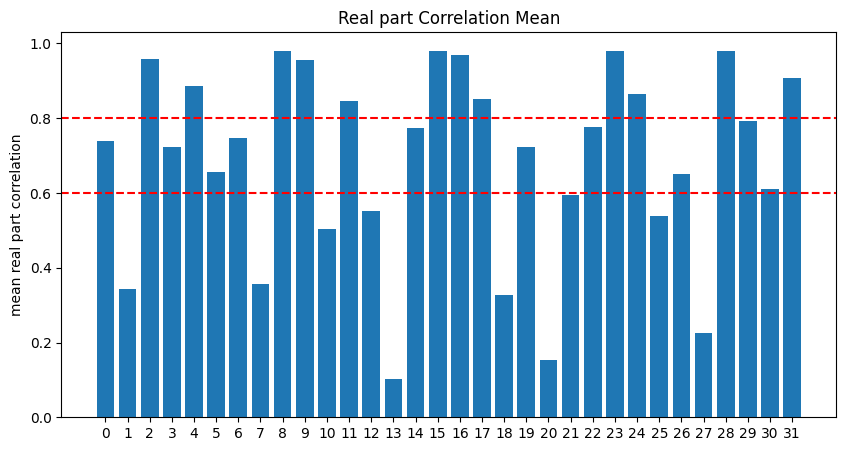

[0, 0, 512, 0, 0, 0, 0, 0, 0, 512, 0, 512, 0, 0, 0, 0, 0, 512, 0, 0, 0, 0, 7, 0, 512, 0, 0, 0, 0, 197, 0, 512]
[0, 0, 512, 0, 0, 0, 0, 0, 0, 512, 0, 512, 0, 0, 0, 0, 0, 512, 0, 0, 0, 0, 4, 0, 512, 0, 0, 0, 0, 191, 0, 512]


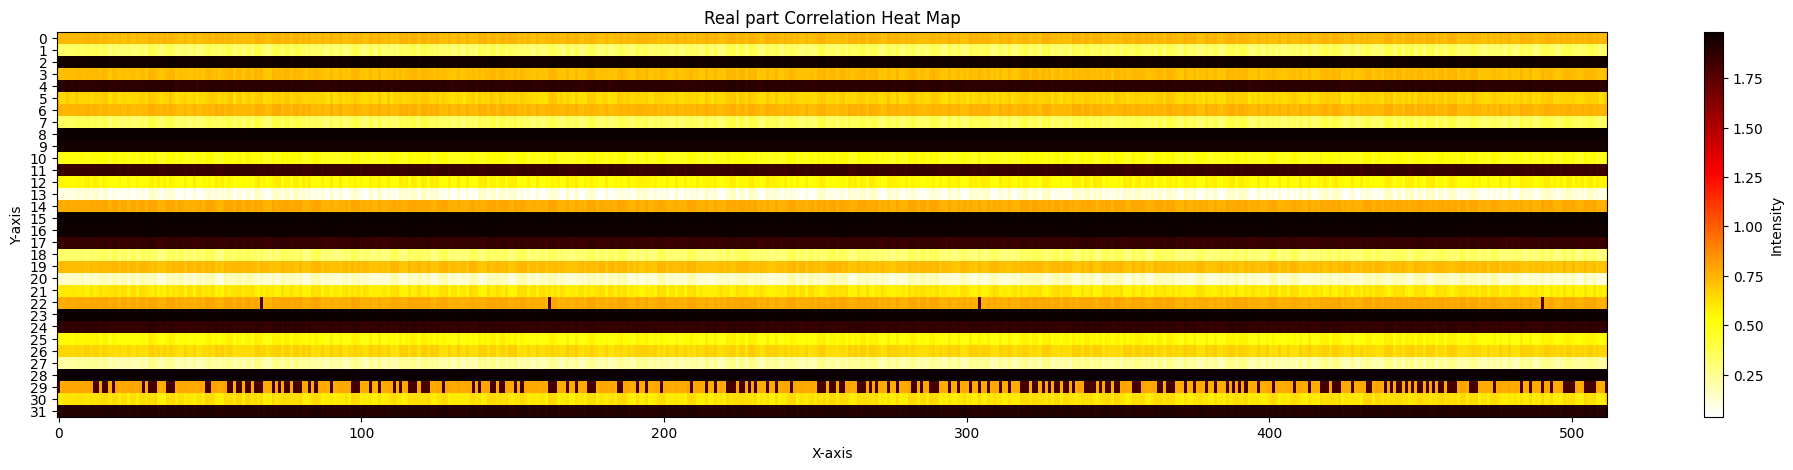

In [30]:

real_corr = []
imag_corr = []
for i in range(0,16):
    for k in range(16,18):
        real_corr_temp,imag_corr_temp = PCCCalculation(sig[:,i],sig[:,k])
        real_corr.append(real_corr_temp)
        imag_corr.append(imag_corr_temp)
mean_real_corr = np.mean(np.abs(real_corr),axis = 1)
mean_imag_corr = np.mean(np.abs(imag_corr),axis = 1)
plt.figure(figsize=(10,5))
plt.bar(range(32),mean_real_corr)
plt.ylabel('mean real part correlation')
plt.axhline(y=0.8, color='red', linestyle='--', label='y = 0.8')
plt.axhline(y=0.6, color='red', linestyle='--', label='y = 0.8')
plt.xticks(range(0, 32, 1))
plt.title('Real part Correlation Mean')
plt.show()

count_strong_real_corr = []
count_strong_imag_corr = []
for i in range(0,32):
    strong_real_corr = (real_corr[i] > 0.8)
    strong_imag_corr = (imag_corr[i] > 0.8)
    count_strong_real_corr.append(strong_real_corr.sum())
    count_strong_imag_corr.append(strong_imag_corr.sum())
    
print(count_strong_real_corr)
print(count_strong_imag_corr)
imag_corr = np.array(np.abs(imag_corr))
imag_corr[imag_corr >= 0.8] += 1
#heat plot
plt.figure(figsize=(25,5))
plt.imshow(imag_corr,aspect='auto',cmap='hot_r',interpolation='none')
plt.colorbar(label='Intensity')  # Add a color bar
plt.title("Real part Correlation Heat Map")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.yticks(range(0, 32, 1))
plt.show()

In [4]:
def frequencyBandDivision(sig, fd, bands):
    fft = np.abs(np.fft.fft(sig))
    sampling_frequency = common.getRate(fd)
    freqs = np.fft.fftfreq(len(sig),1/sampling_frequency)
    band_mask1 = (freqs >= bands[0,0]) & (freqs < bands[0,1])
    fft1 = fft * band_mask1
    band_mask2 = (freqs >= bands[1,0]) & (freqs < bands[1,1])
    fft2 = fft * band_mask2
    band_mask3 = (freqs >= bands[2,0]) & (freqs < bands[2,1])
    fft3 = fft * band_mask3
    return fft1,fft2,fft3

def TFCalculation(sig,fd,bands,channel=18):
    fft1 = []
    fft2 = []
    fft3 = []
    for i in range(0,18):
        fft1_temp,fft2_temp,fft3_temp = frequencyBandDivision(sig,fd,bands)
        fft1.append(fft1_temp)
        fft2.append(fft2_temp)
        fft3.append(fft3_temp)
    MRISignal1 = fft1[0:16]
    MRISignal2 = fft2[0:16]
    MRISignal3 = fft3[0:16]
    if channel == 18:
        EMISignal1 = fft1[16:18]
        EMISignal2 = fft2[16:18]
        EMISignal3 = fft3[16:18]
    else:
        EMISignal1 = fft1[channel]
        EMISignal2 = fft2[channel]
        EMISignal3 = fft3[channel]
    tf1 = np.zeros((16,2),dtype= np.complex64)
    tf1 = np.dot(MRISignal1,np.linalg.pinv(EMISignal1.reshape(1,len(EMISignal1))))
    tf2 = np.zeros((16,2),dtype= np.complex64)
    tf2 = np.dot(MRISignal2,np.linalg.pinv(EMISignal2.reshape(1,len(EMISignal1))))
    tf3 = np.zeros((16,2),dtype= np.complex64)
    tf3 = np.dot(MRISignal3,np.linalg.pinv(EMISignal3.reshape(1,len(EMISignal1))))
    return tf1,tf2,tf3


def denoising(sig,fd,bands,channel):
    tf1,tf2,tf3 = TFCalculation(sig[0],fd,bands,channel)

    fft1 = []
    fft2 = []
    fft3 = []
    for i in range(0,18):
        fft1_temp,fft2_temp,fft3_temp = frequencyBandDivision(sig[128],fd,bands)
        fft1.append(fft1_temp)
        fft2.append(fft2_temp)
        fft3.append(fft3_temp)
    MRISignal1 = fft1[0:16]
    MRISignal2 = fft2[0:16]
    MRISignal3 = fft3[0:16]
    if channel == 18:
        EMISignal1 = fft1[16:18]
        EMISignal2 = fft2[16:18]
        EMISignal3 = fft3[16:18]
    else:
        EMISignal1 = fft1[channel]
        EMISignal2 = fft2[channel]
        EMISignal3 = fft3[channel]
    denoised = sig[128,0:16]

    pred1 = np.dot(EMISignal1,tf1)
    pred2 = np.dot(EMISignal2,tf2)
    pred3 = np.dot(EMISignal3,tf3)
    pred = np.concatenate((pred1,pred2,pred3),axis=1)
    denoised = denoised - np.fft.ifft(pred)
    return denoised



In [5]:
def TFCalculation2(sig,channel=18):
    MRISignal = sig[0:16]
    if channel == 18:
        EMISignal = sig[16:18]
        tf = np.zeros((16,2),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal))
    else:
        EMISignal = sig[channel]
        tf = np.zeros((16,1),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal.reshape(1,len(EMISignal))))
    return tf

def denoising2(sig,channel2=18):
    tf = TFCalculation2(sig[0], channel2)
    denoised = np.zeros((511,16,512),dtype=np.complex64)
    for i in range(511):
        if channel2 == 18:
            EMISignal = sig[i+1,16:18]
            pred = np.dot(tf,EMISignal)
            denoised[i] = sig[i+1,0:16] - pred
        else:
            EMISignal = sig[i+1,channel2]
            pred = np.dot(tf,EMISignal.reshape(1,512))
            denoised[i] = sig[i+1,0:16] - pred
    return denoised

def denoising3(sig,channel2=18):
    tf = TFCalculation2(sig[0], channel2)
    denoised = sig[128,0:16]
    if channel2 == 18:
        EMISignal = sig[128,16:18]
        pred = np.dot(tf,EMISignal)
        denoised = denoised - pred
    else:
        EMISignal = sig[128,channel2]
        pred = np.dot(tf,EMISignal.reshape(1,512))
        denoised = denoised - pred
    
    return denoised

In [12]:
def mean(sig):
    return np.mean(sig)

def peak(sig):
     return np.max(sig)

def std(sig):
     return np.std(sig, dtype=np.float64)

# before suppression/ after suppression of channel 16/ suppression rate (SR)/ after channel 17/ suppression rate / after channel 16+17/ suppression rate
# mean
# peak
# standard deviation
# PCC
def experiment1DTable(before,sup16,sup17,supComb):
    meanBefore = mean(before)
    peakBefore = peak(before)
    stdBefore = std(before)
    meanSup16 = mean(sup16)
    peakSup16 = peak(sup16)
    stdSup16 = std(sup16)
    SRMeanSup16 = 1 - (np.abs(meanSup16)/np.abs(meanBefore))
    SRPeakSup16 = 1 - (np.abs(peakSup16)/np.abs(peakBefore))
    SRStdSup16 = 1 - (np.abs(stdSup16)/np.abs(stdBefore))
    meanSup17 = mean(sup17)
    peakSup17 = peak(sup17)
    stdSup17 = std(sup17)
    SRMeanSup17 = 1 - (np.abs(meanSup17)/np.abs(meanBefore))
    SRPeakSup17 = 1 - (np.abs(peakSup17)/np.abs(peakBefore))
    SRStdSup17 = 1 - (np.abs(stdSup17)/np.abs(stdBefore))
    meanSupComb = mean(supComb)
    peakSupComb = peak(supComb)
    stdSupComb = std(supComb)
    SRMeanSupComb = 1 - (np.abs(meanSupComb)/np.abs(meanBefore))
    SRPeakSupComb = 1 - (np.abs(peakSupComb)/np.abs(peakBefore))
    SRStdSupComb = 1 - (np.abs(stdSupComb)/np.abs(stdBefore))
    table = PrettyTable(["","Before suppression", "After suppression with Channel 16",
                          "Suppression Rate1", "After suppression with Channel 17",
                          "Suppression Rate2","After suppression with Channel 16 and 17",
                          "Suppression Rate3"])
    table.add_row(["mean",meanBefore,meanSup16,SRMeanSup16,meanSup17,SRMeanSup17,meanSupComb,SRMeanSupComb]) 
    table.add_row(["peak",peakBefore,peakSup16,SRPeakSup16,peakSup17,SRPeakSup17,peakSupComb,SRPeakSupComb]) 
    table.add_row(["standard deviation",stdBefore,stdSup16,SRStdSup16,stdSup17,SRStdSup17,stdSupComb,SRStdSupComb]) 
    print(table)

In [ ]:

sup16 = denoising2(sig,channel2=16)

sup17 = denoising2(sig,channel2=17)
supcomb = denoising2(sig,channel2=18)
before = np.mean(sig[1:512,0:16],axis=0)
sup16 = np.mean(sup16, axis = 0)
sup17 = np.mean(sup17, axis = 0)
supcomb = np.mean(supcomb, axis = 0)

experiment1DTable(sig[128,0:16],sup16[127],sup17[127],supcomb[127])
before = np.mean(sig[1:512,0:16],axis=0)
sup16 = np.mean(sup16, axis = 0)
sup17 = np.mean(sup17, axis = 0)
supcomb = np.mean(supcomb, axis = 0)


+--------------------+----------------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|                    |     Before suppression     | After suppression with Channel 16 | Suppression Rate1  | After suppression with Channel 17 | Suppression Rate2  | After suppression with Channel 16 and 17 | Suppression Rate3  |
+--------------------+----------------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|        mean        | (0.0039129257+0.63346934j) |     (-0.05532783+0.022340259j)    |     0.9058096      |    (-0.04600215+0.0021661557j)    |     0.9273015      |       (-0.044422373+0.0069092102j)       |     0.9290327      |
|        peak        |   (576.5794-0.40318486j)   |       (48.890533-17.413443j)

In [ ]:
#fd = 'E:/JiaxingData/EMINoise/1209/AMSquareFA0_1.h5'
#bands = np.array([[0,5000],[5000,15000],[15000,32000]])
sup16 = denoising2(sig,channel2=16)
#sup16 = denoising3(sig,channel2=16)
sup17 = denoising2(sig,channel2=17)
supcomb = denoising2(sig,channel2=18)
before = np.mean(sig[1:512,0:16],axis=0)
sup16 = np.mean(sup16, axis = 0)
sup17 = np.mean(sup17, axis = 0)
supcomb = np.mean(supcomb, axis = 0)

experiment1DTable(sig[128,0:16],sup16[127],sup17[127],supcomb[127])
before = np.mean(sig[1:512,0:16],axis=0)
sup16 = np.mean(sup16, axis = 0)
sup17 = np.mean(sup17, axis = 0)
supcomb = np.mean(supcomb, axis = 0)

In [10]:
def experiment1D(sig):


    # step2
    sup16 = denoising2(sig,channel2=16)
    sup17 = denoising2(sig,channel2=17)
    supcomb = denoising2(sig,channel2=18)
    before = np.mean(sig[1:512,0:16],axis=0)
    sup16 = np.mean(sup16, axis = 0)
    sup17 = np.mean(sup17, axis = 0)
    supcomb = np.mean(supcomb, axis = 0)
    # step3
    experiment1DTable(before,sup16,sup17,supcomb)

In [20]:
date = '1209'
for mode in ['AM']:
    for type in ['Square','Sine']:
        for trial in ['1','2','3','4','5']:
            flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'FA0_'+trial+'.h5')
            flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))
            experiment1D(flip0)


+--------------------+---------------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|                    |     Before suppression    | After suppression with Channel 16 | Suppression Rate1  | After suppression with Channel 17 | Suppression Rate2  | After suppression with Channel 16 and 17 | Suppression Rate3  |
+--------------------+---------------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|        mean        | (0.024655782+0.06451108j) |   (-0.0056348126-0.0009637575j)   |     0.91722476     |    (-0.005541321-0.0016389829j)   |     0.91632724     |      (-0.0055294493-0.0014856642j)       |     0.91709566     |
|        peak        |   (22.529398-12.640425j)  |      (3.0312164-0.030395515j)    

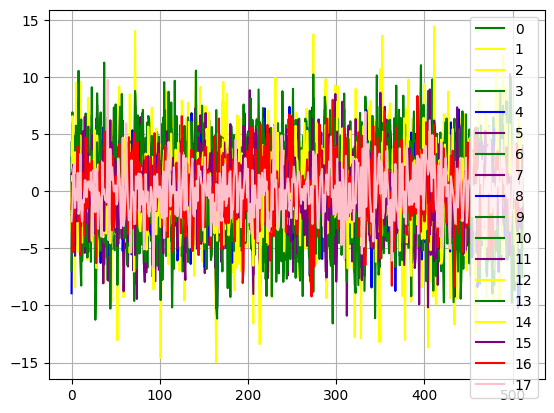

In [53]:
flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/1209/0115/AMSquareBFA0.h5')
flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))
sampling_frequency = common.getRate('C:/JiaxingData/EMINoise/1209/0115/AMSquareBFA0.h5')
freqs = np.fft.fftfreq(len(flip0),1/sampling_frequency)

plt.plot(np.real(flip0[0,0]),'g')
plt.plot(np.real(flip0[0,1]),'yellow')
plt.plot(np.real(flip0[0,2]),'yellow')
plt.plot(np.real(flip0[0,3]),'g')
plt.plot(np.real(flip0[0,4]),'blue')
plt.plot(np.real(flip0[0,5]),'purple')
plt.plot(np.real(flip0[0,6]),'g')
plt.plot(np.real(flip0[0,7]),'purple')
plt.plot(np.real(flip0[0,8]),'blue')
plt.plot(np.real(flip0[0,9]),'g')
plt.plot(np.real(flip0[0,10]),'g')
plt.plot(np.real(flip0[0,11]),'purple')
plt.plot(np.real(flip0[0,12]),'yellow')
plt.plot(np.real(flip0[0,13]),'g')
plt.plot(np.real(flip0[0,14]),'yellow')
plt.plot(np.real(flip0[0,15]),'purple')
plt.plot(np.real(flip0[0,16]),'red')
plt.plot(np.real(flip0[0,17]),'pink')
#plt.xlim(9500,10500)
#plt.ylim(0,45000)
plt.grid()
plt.legend(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'])
    #plt.savefig('E:/JiaxingData/EMINoise/'+date+'/spectrumPlot/'+mode+type+trial+'_absFFT_'+str(i1)+'_'+str(i2)+'.png')
    #plt.plot(freqs[:len(freqs)//2],np.abs(fft)[:len(freqs)//2])
plt.show()

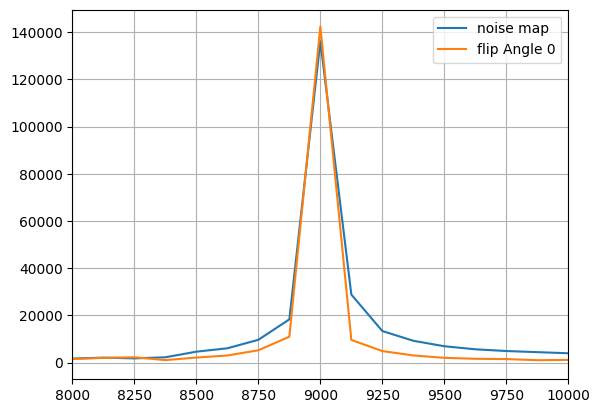

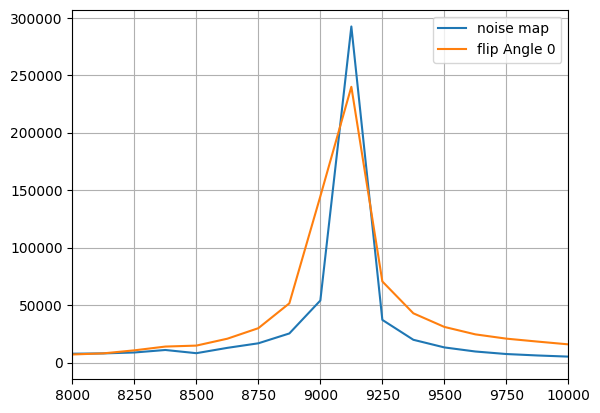

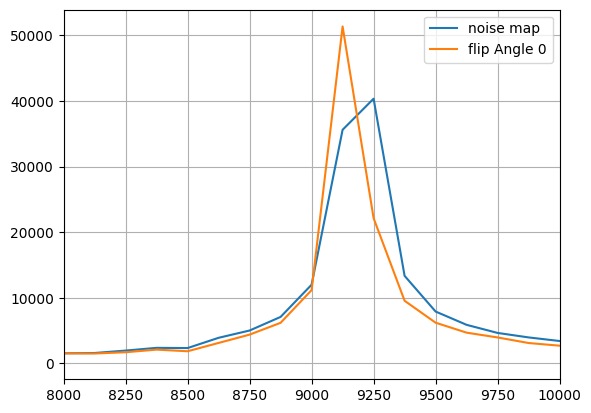

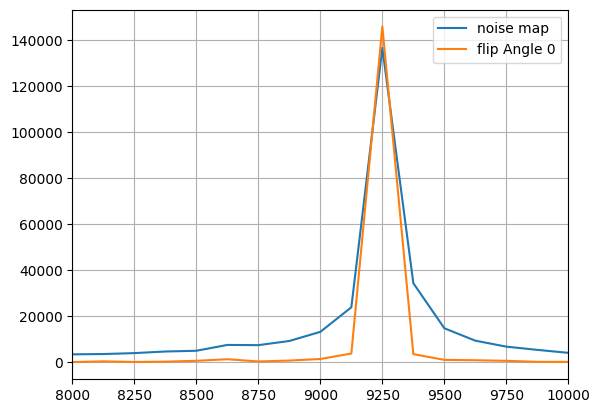

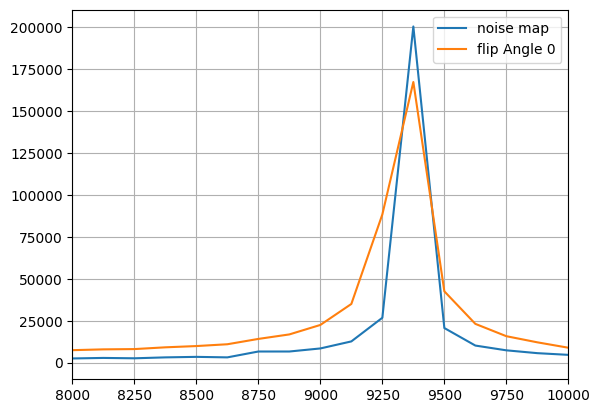

In [41]:
def plotAcqSamples(flip0,noisePre0,date,mode,type,trial):
    
    i1 = np.random.randint(0,len(flip0))
    i2 = np.random.randint(0,16)
    
    #noiseImage = noiseImage[i1,i2] - baseline[i1,i2]
    flip0 = flip0[i1,i2]
    noisePre0 = noisePre0[0,i2,0:512]

    #fft1 = np.fft.fft(noiseOnly)
    fft3 = np.fft.fft(flip0)
    fft5 = np.fft.fft(noisePre0)
    #phase1 = np.angle(fft1)
    #ps1 = 20*np.log10(np.abs(fft1)**2)


    #sampling_frequency1 = common.getRate('E:/JiaxingData/EMINoise/0827/NoiseSignal_32_256.h5')
    sampling_frequency3 = common.getRate('C:/JiaxingData/EMINoise/'+date+'/0115/'+mode+type+'SFA0_'+trial+'.h5')
    #freqs1 = np.fft.fftfreq(len(noiseOnly),1/sampling_frequency1)
    freqs3 = np.fft.fftfreq(len(flip0),1/sampling_frequency3)




    #plt.plot(freqs1[:len(freqs1)//2],np.abs(fft1)[:len(freqs1)//2])

    plt.plot(freqs3[:len(freqs3)//2],np.abs(fft3)[:len(freqs3)//2])

    plt.plot(freqs3[:len(freqs3)//2],np.abs(fft5)[:len(freqs3)//2])
    plt.xlim(8000, 10000)
    plt.grid()
    plt.legend(['noise map','flip Angle 0','regular noise preScan', '0FlipAngle noise preScan'])
    #plt.savefig('E:/JiaxingData/EMINoise/'+date+'/spectrumPlot/'+mode+type+trial+'_absFFT_'+str(i1)+'_'+str(i2)+'.png')
    #plt.plot(freqs[:len(freqs)//2],np.abs(fft)[:len(freqs)//2])
    plt.show()
    
    date = '1209'
for mode in ['AM']:
    for type in ['Square']:
        for trial in ['1','2','3','4','5']:
            #noiseOnly,b = common.readAllAcqs('E:/JiaxingData/EMINoise/1205/FA0Run1.h5')
            #noiseOnly = dp.ConvergeComplexR(dp.SplitComplexR(noiseOnly))
            #noiseImage,b = common.readAllAcqs('E:/JiaxingData/EMINoise/'+date+'/'+mode+type+'FA77_'+trial+'.h5')
            #noiseImage = dp.ConvergeComplexR(dp.SplitComplexR(noiseImage))
            #baseline,b = common.readAllAcqs('E:/JiaxingData/EMINoise/'+date+'/FA77Baseline.h5')
            #baseline = dp.ConvergeComplexR(dp.SplitComplexR(baseline))
            flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/0115/'+mode+type+'SFA0_'+trial+'.h5')
            flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))
            #noisePre,b = common.readAllAcqs('E:/JiaxingData/EMINoise/'+date+'/0115/'+mode+type+'FA77_'+trial+'.h5',table_name="noise")
            #noisePre = dp.ConvergeComplexR(dp.SplitComplexR(noisePre))
            noisePre0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/0115/'+mode+type+'SFA0_'+trial+'.h5',table_name="noise")
            noisePre0 = dp.ConvergeComplexR(dp.SplitComplexR(noisePre0))
            
            plotAcqSamples(flip0,noisePre0,date,mode,type,trial)

20
20


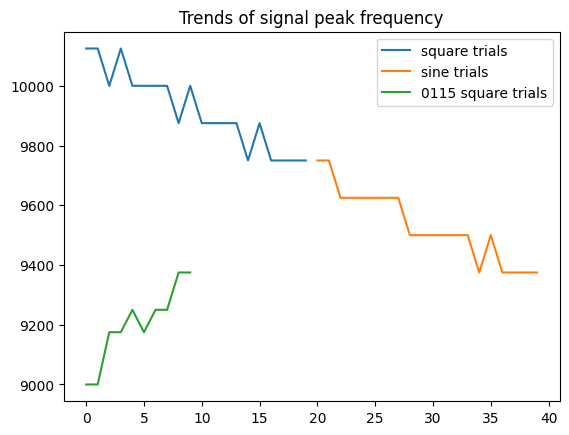

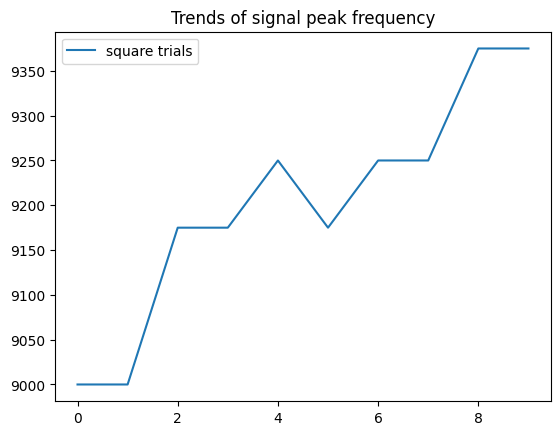

In [61]:
data1 = [10125,10125,10000,10125,10000,10000,10000,10000,
        9875,10000,9875,9875,9875,9875,9750,9875,
        9750,9750,9750,9750]
print(len(data1))
data2 = [9750,9750,9625,9625,9625,9625,9625,9625,
         9500,9500,9500,9500,9500,9500,9375,9500,
         9375,9375,9375,9375]
DATA = [9000,9000,9175,9175,9250,9175,9250,9250,9375,9375]
#DATA = [9375,9375,9250,9250,9175,9250,9175,9175,9000,9000]
print(len(data2))
plt.plot(range(20),data1)
plt.plot(range(20,40),data2)
plt.plot(range(10),DATA)
plt.legend(['square trials','sine trials','0115 square trials'])
plt.title('Trends of signal peak frequency')
plt.show()
plt.plot(DATA)
plt.legend(['square trials','sine trials','0115 square trials'])
plt.title('Trends of signal peak frequency')
plt.show()

In [ ]:
    # step1
    real_corr = []
    imag_corr = []
    for i in range(0,16):
        for k in range(16,18):
            real_corr_temp,imag_corr_temp = PCCCalculation(sig[:,i],sig[:,k])
            real_corr.append(real_corr_temp)
            imag_corr.append(imag_corr_temp)
    mean_real_corr = np.mean(real_corr,axis=0)
    mean_real_corr = np.mean(np.abs(real_corr))
    mean_imag_corr = np.mean(np.abs(imag_corr))
    print(mean_real_corr)
    print(mean_imag_corr)

    count_strong_real_corr = []
    count_strong_imag_corr = []

    for i in range(0,32):
        strong_real_corr = (real_corr[i] > 0.8)
        strong_imag_corr = (imag_corr[i] > 0.8)
        count_strong_real_corr.append(strong_real_corr.sum())
        count_strong_imag_corr.append(strong_imag_corr.sum())
    print(count_strong_real_corr)
    print(count_strong_imag_corr)
    
    real_corr = np.array(np.abs(real_corr))
    real_corr[real_corr >= 0.8] += 1
    #heat plot
    plt.figure(figsize=(25,5))
    plt.imshow(real_corr,aspect='auto',cmap='viridis_r',interpolation='none')
    plt.colorbar(label='Intensity')  # Add a color bar
    plt.title("Real part Correlation Heat Map")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.yticks(range(0, 32, 1))
    plt.show()
    
    imag_corr = np.array(np.abs(imag_corr))
    imag_corr[imag_corr >= 0.8] += 1
    plt.figure(figsize=(25,5))
    plt.imshow(imag_corr,aspect='auto',cmap='viridis_r',interpolation='none')
    plt.colorbar(label='Intensity')  # Add a color bar
    plt.title("Imagery part Correlation Heat Map")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.yticks(range(0, 32, 1))
    plt.show() 

In [50]:
#calculate overall transfer function
def TFCalculation2(sig,channel=18):
    MRISignal = sig[0:16]
    if channel == 18:
        EMISignal = sig[16:18]
        tf = np.zeros((16,2),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal))
    else:
        EMISignal = sig[channel]
        tf = np.zeros((16,1),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal.reshape(1,len(EMISignal))))
    return tf

def denoising2(sig,channel2=18):
    tf = TFCalculation2(sig[0], channel2)
    denoised = np.zeros((511,16,512),dtype=np.complex64)
    for i in range(511):
        if channel2 == 18:
            EMISignal = sig[i+1,16:18]
            pred = np.dot(tf,EMISignal)
            denoised[i] = sig[i+1,0:16] - pred
        else:
            EMISignal = sig[i+1,channel2]
            pred = np.dot(tf,EMISignal.reshape(1,512))
            denoised[i] = sig[i+1,0:16] - pred
    return denoised

long = []
date = '1209'
for mode in ['AM']:
    for type in ['Square']:
        for trial in ['1','2','3','4','5']:
            flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'FA0_'+trial+'.h5')
            flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))
            for i in range(512):
                long.append(flip0[i])
long = np.array(long)
longSize = long.shape
long = long.transpose(1, 0, 2).reshape(longSize[1],longSize[0]*longSize[2])
print(long.shape)
tf = TFCalculation2(long, 18)

print(tf)

                


(18, 1310720)
[[ 1.8900120e-01+0.1881694j  -4.6714881e-01-1.2638929j ]
 [ 2.5561607e-01+0.22851455j -1.1475556e+00-1.014012j  ]
 [-4.8984177e-02-0.00756874j  3.7694480e-02+0.03956681j]
 [ 1.3043512e-01+0.04286338j -8.2856171e-02-0.28369147j]
 [-3.6685133e-01+0.15095316j  1.7517471e+00+0.5831409j ]
 [ 2.1461695e-02+0.08473425j  4.6829769e-01-0.25783882j]
 [ 1.1661104e-01+0.03034258j  9.8129408e-04-0.3264966j ]
 [ 7.4239410e-02-0.16858733j -9.0119696e-01+0.14381357j]
 [-2.4392840e-02+0.05638974j  9.4385825e-02+0.07896766j]
 [-7.6783210e-02-0.04269595j -1.7289595e-01+0.10810833j]
 [ 1.1870117e-01+0.20368479j  2.8065693e-01-0.2744792j ]
 [ 2.8979208e-02-0.11516361j -3.4162959e-01+0.03594493j]
 [ 3.8273916e-02+0.06328033j -2.5832880e-01-0.37282097j]
 [-5.4598039e-01-0.63362j     5.6895846e-01+2.4676507j ]
 [-8.2478449e-02+0.03509756j  2.2547124e-01+0.19983274j]
 [-4.1031491e-02+0.22415495j  3.9215541e-01-0.1295193j ]]
